In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.sixb.feynnet

In [15]:
sig_pattern = module.NMSSM_XYH_YToHH_6b_MX_700_MY_300.replace('MX-700_MY-300','{mass}')

masses = [
    "MX-800_MY-400",
    "MX-900_MY-300",
    "MX-900_MY-400",
    "MX-900_MY-500",
    "MX-1000_MY-400",

]

In [16]:
trained = [0,1,3,4]
toeval  = [2]

In [17]:
def use_test(f):
    return f.replace('ntuple','test_ntuple')

In [18]:
signal = ObjIter([Tree(use_test( sig_pattern.format(mass=f) ), report=False, ) for f in tqdm(masses)])
bkg = ObjIter([Tree(map(use_test,module.Run2_UL18.QCD_B_List))])

100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


In [19]:
import utils.sixbUtils as sixb

model = sixb.models.feynnet_sig_mass_square
(signal + bkg).apply( lambda t : sixb.weaver.load_yh_trih_ranker(t, model.path), report=True )

100%|██████████| 6/6 [00:33<00:00,  5.57s/it]


[None, None, None, None, None, None]

In [20]:
def fully_reconstructed(t):

    reco_hx = t.HX_signalId == 0
    reco_y  = ( (t.H1_signalId+1)//2 == 1) & ( (t.H2_signalId+1)//2 == 1)
    
    reco_id = ak.where( reco_hx & reco_y, 0, -1)
    t.extend(
        reco_id = reco_id
    )
(signal).apply(fully_reconstructed)

[None, None, None, None, None]

In [21]:
sixb_signal = signal.apply(EventFilter('all_sixb', filter=lambda t : t.nfound_select==6))
partial_signal = signal.apply(EventFilter('partial_sixb', filter=lambda t : t.nfound_select< 6))

In [19]:
sixb_signal.sample

['MX_700_MY_300', 'MX_800_MY_300', 'MX_800_MY_350', 'MX_900_MY_300', 'MX_900_MY_400', 'MX_1000_MY_350', 'MX_1000_MY_450', 'MX_1200_MY_450']

100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


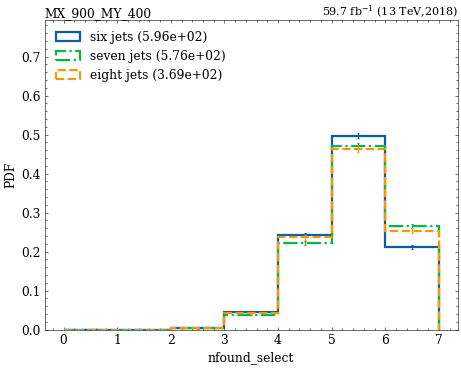

In [47]:
study.compare_masks(
    signal[toeval],
    masks=[lambda t:t.n_jet==6,lambda t:t.n_jet == 7,lambda t:t.n_jet == 8],
    label=['six jets','seven jets','eight jets'],
    varlist=['nfound_select'],
    efficiency=True,
    legend=True,
)

In [32]:
sorted(tree.fields)

['Event',
 'H1_b1_btag',
 'H1_b1_eta',
 'H1_b1_genHflag',
 'H1_b1_m',
 'H1_b1_phi',
 'H1_b1_pt',
 'H1_b2_btag',
 'H1_b2_eta',
 'H1_b2_genHflag',
 'H1_b2_m',
 'H1_b2_phi',
 'H1_b2_pt',
 'H1_eta',
 'H1_m',
 'H1_phi',
 'H1_pt',
 'H1_signalId',
 'H2_b1_btag',
 'H2_b1_eta',
 'H2_b1_genHflag',
 'H2_b1_m',
 'H2_b1_phi',
 'H2_b1_pt',
 'H2_b2_btag',
 'H2_b2_eta',
 'H2_b2_genHflag',
 'H2_b2_m',
 'H2_b2_phi',
 'H2_b2_pt',
 'H2_eta',
 'H2_m',
 'H2_phi',
 'H2_pt',
 'H2_signalId',
 'HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5',
 'HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5_ObjectMatched',
 'HX_b1_btag',
 'HX_b1_eta',
 'HX_b1_genHflag',
 'HX_b1_m',
 'HX_b1_phi',
 'HX_b1_pt',
 'HX_b2_btag',
 'HX_b2_eta',
 'HX_b2_genHflag',
 'HX_b2_m',
 'HX_b2_phi',
 'HX_b2_pt',
 'HX_eta',
 'HX_m',
 'HX_phi',
 'HX_pt',
 'HX_signalId',
 'LHEPdfWeight',
 'LHEPdfWeight_var0',
 'LHEPdfWeight_var1',
 'LHEPdfWeight_var10',
 'LHEPdfWeight_var100',
 'LHEPdfWeight_var11',
 'LHEPdfWeight_var12

100%|██████████| 1/1 [00:04<00:00,  4.44s/it]

x_mean=2.000
x_std=1.414
x_min=0.000
x_max=4.000
y_mean=0.608
y_std=0.115
y_min=0.455
y_max=0.760
x_sum=10.000
y_sum=3.041
area=2.386
ndf=5.000


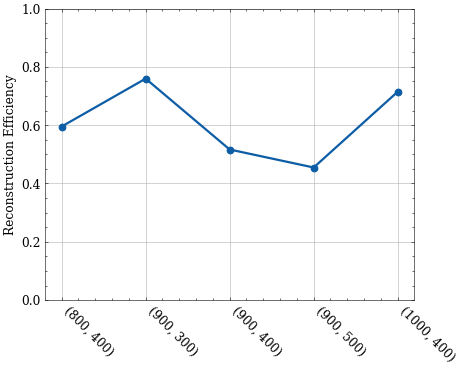

In [22]:
study.statsplot(
    sixb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    binlist=[np.array([-1,0,1])],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,

    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
    g_ylim=(0,1),
)

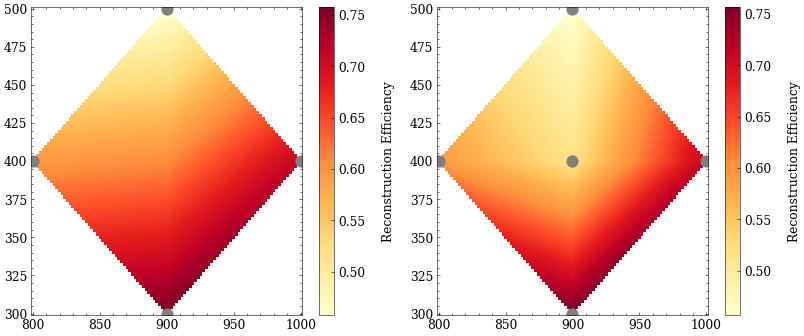

In [50]:
fig, axs = study.get_figax(nvar=2)
study.mxmy_phase(
    sixb_signal[trained],
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    # zlim=np.linspace(0,1,5),

    figax=(fig, axs[0])
)

study.mxmy_phase(
    sixb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    # zlim=np.linspace(0,1,5),
    figax=(fig, axs[1])

)

100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


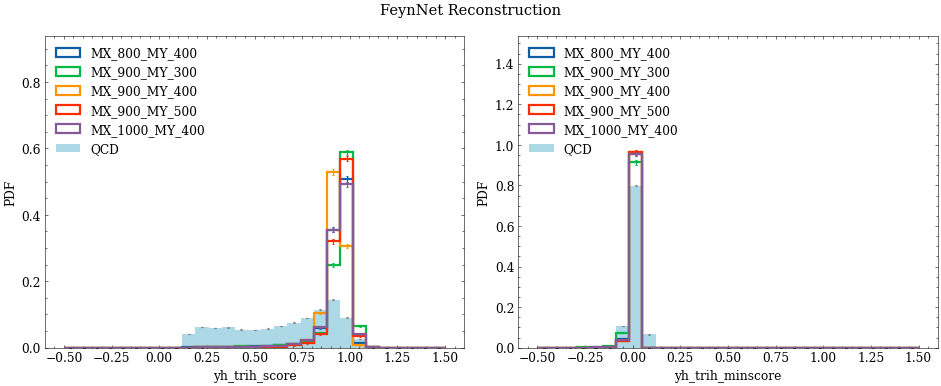

In [27]:
study.quick(
    sixb_signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['yh_trih_score','yh_trih_minscore'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    efficiency=True,
    lumi=None,
    # **study.auroc,
)

In [28]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y_m =  dict(bins=(100,1000,30), xlabel='Y Boson Mass (GeV)')
varinfo.HX_m =   dict(bins=(0,300,30), xlabel='X\'s Higgs Boson Mass (GeV)')
varinfo.H1_m =   dict(bins=(0,300,30), xlabel='Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2_m =   dict(bins=(0,300,30), xlabel='Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


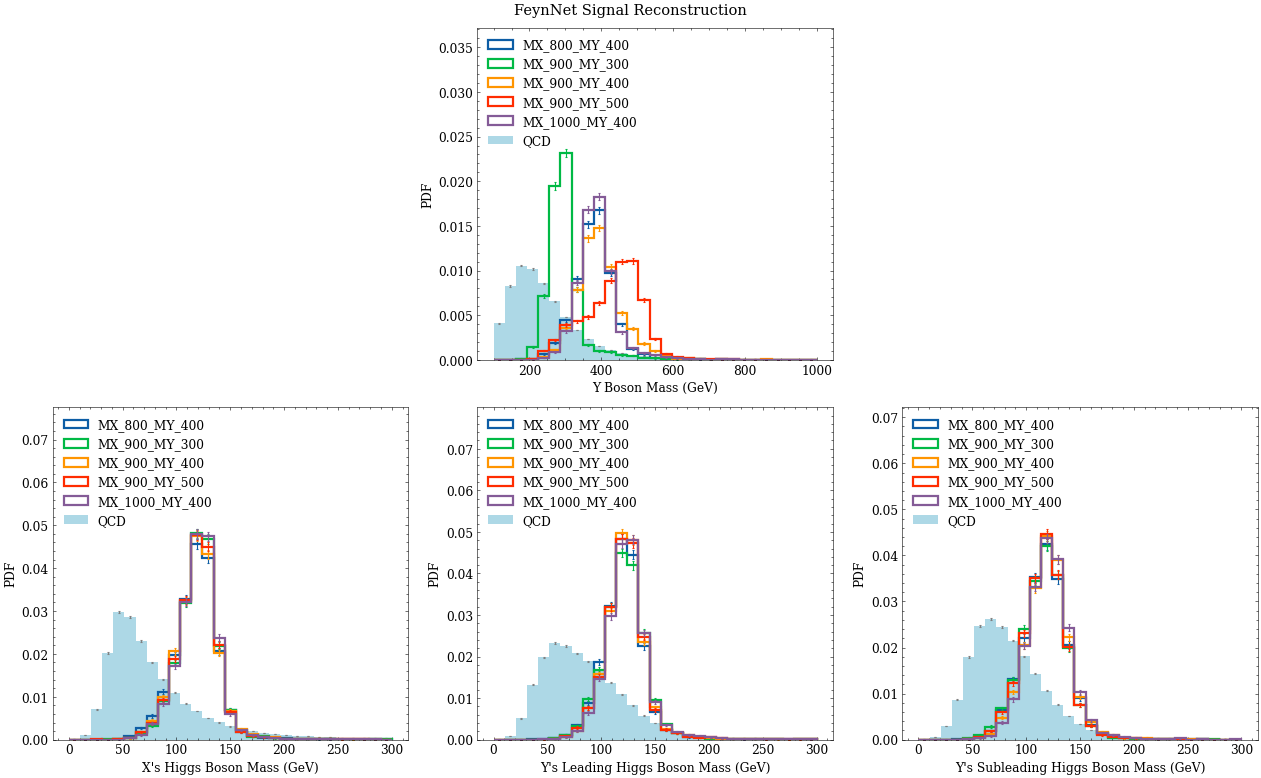

In [29]:
study.quick(
    sixb_signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y_m',None,'HX_m','H1_m','H2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)